In [ ]:
PLOTTING


In [1]:
import numpy as np
import matplotlib.pyplot as plt           #We use it for construction of graphs, both 3D and 2D
import math
import matplotlib as mpl
import pandas as pd

import json
import os
import requests

# spatial stuff
import geopandas as gpd
import fiona
import folium
import shapely
from descartes import PolygonPatch
from tqdm import tqdm
#!conda install -U scikit -learn
from sklearn.neighbors import KNeighborsRegressor




In [9]:
#conda install contextily --channel conda-forge

In [2]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}


url_map = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson" # KOMMUNE DATA
kommuner = gpd.read_file(url_map)

# Convert to metres
kommuner.to_crs({'init':'epsg:25832'},inplace=True) #

bounds = kommuner.bounds

# get min or max of each column

min_max_bounds = []

for columns in bounds.columns[:2]:
    min_max_bounds.append(min(bounds[columns]))
    
for columns in bounds.columns[-2:]:
    min_max_bounds.append(max(bounds[columns]))
min_max_bounds




C:\PythonMan\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


[441675.99999999994, 6049781.999990508, 892786.9996185575, 6402216.999996983]

<ipython-input-3-530400cb4d98>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  GeoPopData.crs = {'init': 'epsg:3035', 'no_defs': True}
C:\PythonMan\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\PythonMan\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\PythonMan\

The CRS is: {'init': 'epsg:25832', 'no_defs': True}
The CRS is: {'init': 'epsg:25832', 'no_defs': True}


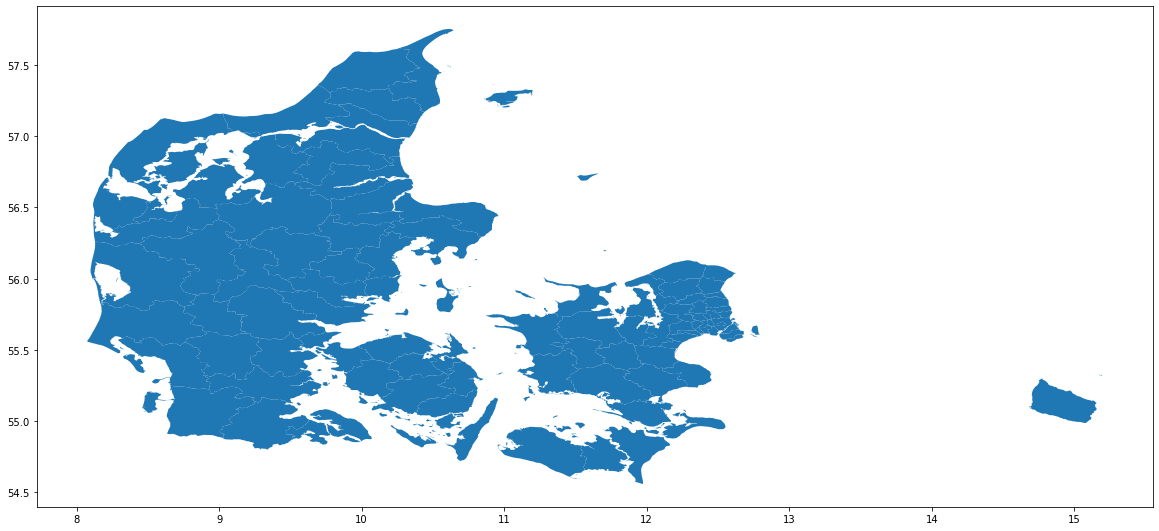

In [3]:
GeoPopData = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/GeoPopData_DK.csv") #POP DATA
#gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
GeoPopData.crs = {'init': 'epsg:3035', 'no_defs': True}
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url)
Kort = kommuner.plot(figsize=(20,20))
kommuner = kommuner.to_crs(epsg = 25832)

#GeoPopData = GeoPopData.to_crs(espg = 25832)

# %%
GeoPopData['latitude'] = [int(x[4:8])*1000 for x in GeoPopData.GRD_ID]
GeoPopData['longtitude'] = [int(x[9:])*1000 for x in GeoPopData.GRD_ID]
#GeoPopData['longtitude'] = GeoPopData['GRD_ID'][9:]

Pop_gdf = gpd.GeoDataFrame(GeoPopData, geometry=gpd.points_from_xy(GeoPopData.longtitude, GeoPopData.latitude))
Pop_gdf.crs = {'init': 'epsg:3035', 'no_defs': True}
Pop_gdf['test'] = Pop_gdf['geometry'].to_crs(epsg = 4326)
Pop_gdf['test2'] = Pop_gdf['geometry'].to_crs(epsg = 3035)
Pop_gdf = Pop_gdf.to_crs(epsg = 25832)
print('The CRS is:', Pop_gdf.crs)

Pop_gdf['latitude'] = [z.y for z in Pop_gdf.geometry]
Pop_gdf['longtitude'] = [z.x for z in Pop_gdf.geometry]
#Pop_gdf
print('The CRS is:', Pop_gdf.crs)

C:\PythonMan\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


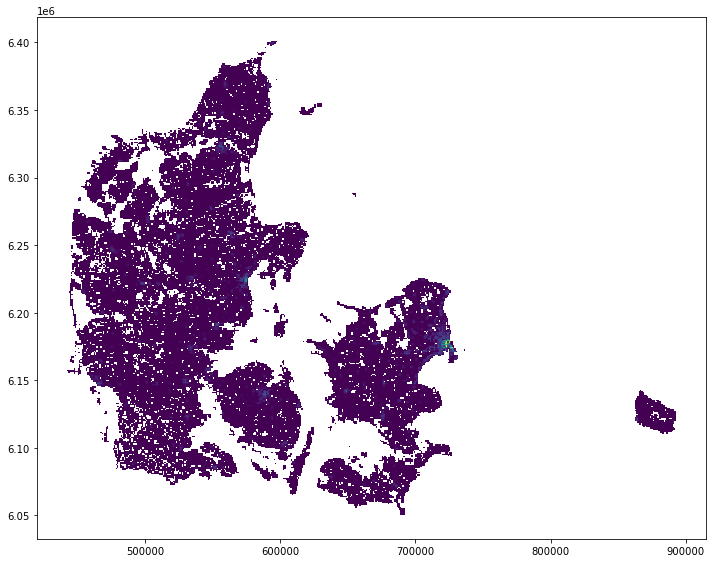

In [16]:
import Function 
import geopandas as gpd
knneg = KNeighborsRegressor(n_neighbors = 25, radius = 25000)

#Pop_gdf['latitude'] = Pop_gdf.geometry.y
#Pop_gdf['longtitude'] = Pop_gdf.geometry.x
#Pop_gdf = Pop_gdf.to_crs(epsg=25832)
square_df = pd.DataFrame(data = Pop_gdf, columns=['latitude','longtitude'])
square_gdf = Function.cell_coords_to_polygons(square_df)
square_gdf = square_gdf.to_crs(epsg=25832)

#square_gdf_join = gpd.sjoin(square_gdf,kommuner)

square_gdf['LA_shifted'] = square_gdf['latitude'] + 500
square_gdf['LO_shifted'] = square_gdf['longtitude'] + 500
#square_gdf_join

# %%
# subset X, y
cols = Pop_gdf[['TOT_P','latitude', 'longtitude']]

X = cols[['longtitude', 'latitude']]

y = cols[['TOT_P']]

KN = KNeighborsRegressor()


KN.fit(X,y)

preds = KN.predict(square_gdf[['LA_shifted', 'LO_shifted']])
                             
square_gdf['pred'] = np.log10(preds)
square_gdf


# %%
new = Pop_gdf[['latitude', 'longtitude', 'TOT_P']]
new_df = pd.merge(square_gdf, new,  how='left', left_on=['latitude','longtitude'], right_on = ['latitude','longtitude'])

empty_list=[]





#%% 
#DETTE ER KODEN VI SKAL BRUGE TIL AT KØRE KORTET MED I SIDSTE ENDE: 
f, ax = plt.subplots(1, figsize=(12, 12))
ax = new_df.plot(column='TOT_P',ax=ax)
plt.show()




In [18]:
gdf = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Main_data_with_geodat.csv")
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitudes, gdf.latitudes))
gdf.crs = {'init': 'epsg:4326', 'no_defs': True}

gdf = gdf.to_crs(epsg =25832)
gdf

C:\PythonMan\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Unnamed: 0,Unnamed: 0.1,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,...,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear,geometry,test
0,0,0,359,Albertslund Apotek,6,Bytorvet 5,2620.0,01Jan1966 0:00:00.000,NaN,1084.0,...,12.353695,1966-01-01,1966.0,2008.0,1966-01-01,NaN,1966.0,NaN,POINT (710970.146 6172951.975),0.000000
1,1,1,346-1,Allerød Apotek,7,Allerød Stationsvej 9,3450.0,NaN,NaN,1084.0,...,12.355782,NaN,NaN,2008.0,NaN,NaN,NaN,NaN,POINT (709944.269 6196827.876),0.214620
2,2,2,082-1,Allinge Apotek,7,Kirkegade 13,3770.0,01May2016 0:00:00.000,NaN,1084.0,...,14.802304,2016-05-01,2016.0,2016.0,2016-05-01,NaN,2016.0,NaN,POINT (868380.605 6140982.861),2.477826
3,3,3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,...,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0,POINT (868380.605 6140982.861),2.477826
4,4,4,243-1,Amager Strand Apotek,7,Strandlodsvej 41,2300.0,21Sep2015 0:00:00.000,NaN,1084.0,...,12.622773,2015-09-21,2015.0,2015.0,2015-09-21,NaN,2015.0,NaN,POINT (727844.496 6174656.155),0.269187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,708,708,331,Aarhus Viby Apotek,6,"Viby Ringvej 10, ST. 26",8260.0,01Jan1933 0:00:00.000,NaN,1082.0,...,10.198700,1933-01-01,1933.0,2008.0,1933-01-01,NaN,1933.0,NaN,POINT (574436.896 6225235.413),2.214472
679,709,709,337,Aarhus Åbyhøj Apotek,6,Haslevej 17,8230.0,01Jan1936 0:00:00.000,NaN,1082.0,...,10.164773,1936-01-01,1936.0,2008.0,1936-01-01,NaN,1936.0,NaN,POINT (572348.706 6224103.984),2.245289
680,710,710,259,Aars Apotek,6,Søndergade 34,9600.0,01Jan1905 0:00:00.000,NaN,1081.0,...,9.519024,1905-01-01,1905.0,2008.0,1905-01-01,NaN,1905.0,NaN,POINT (531696.592 6295478.660),3.057411
681,711,711,106,Aarup Apotek,6,Bredgade 25,5560.0,01-01-1859 00:00,31Dec2008 0:00:00.000,1083.0,...,10.049612,1859-01-01,1859.0,2008.0,1859-01-01,2008-12-31,1859.0,2008.0,POINT (566502.580 6137726.088),2.320460


NameError: name 'gdf' is not defined

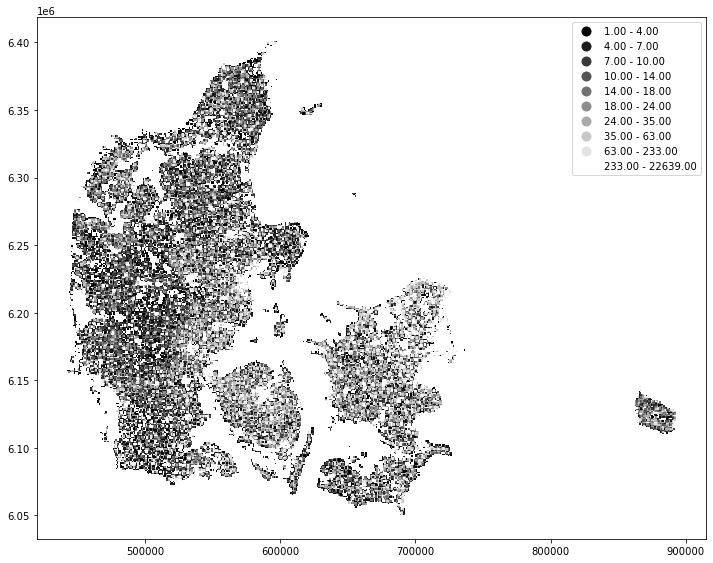

In [5]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax= new_df.plot(column='TOT_P',ax=ax, legend=True, cmap='gray', scheme='quantiles', k=10, linewidth=0.1)
gdf['geometry'].plot(ax=ax , markersize=10)
plt.show()

In [ ]:
DK_shape = gpd.read_file(
  r"C:\Users\Nicklas Lindegaard\Desktop\Speciale\Python\thesis_2020 - midl\Shapefiles")


In [67]:
gdf_Type6 = gdf[(gdf.TypeID==6) | (gdf.Slyear > 2006.0)  | (gdf.Slyear < 2018.0)] 
gdf_Type7 = gdf[(gdf.TypeID==7) | (gdf.Slyear > 2006.0) | (gdf.Slyear < 2018.0)] 
gdf_Type8 = gdf[(gdf.TypeID==8) | (gdf.Slyear > 2006.0) | (gdf.Slyear < 2018.0)] 
#test = gdf_Type6[(gdf.Slyear>2006) | (gdf.Slyear>2006).isnull()]
len(gdf_Type6)+len(gdf_Type7)+len(gdf_Type8)
gdf_Type8

,Unnamed: 0,Unnamed: 0.1,ApotekNr,Navn,TypeID,Adresse,PostNr,Startdato,Slutdato,amt,...,longitudes,dato,year,dummy,Stdato,Sldato,Styear,Slyear,geometry,test
3,3,3,175,Allinge Apotek,6,Kirkegade 13,3770.0,01-01-1898 00:00,01May2016 0:00:00.000,1084.0,...,14.802304,1898-01-01,1898.0,2008.0,1898-01-01,2016-05-01,1898.0,2016.0,POINT (1647784.944 7415836.865),2.477826
10,10,10,090-6,Apotek Illum,7,Østergade 52,1001.0,03Sep2018 0:00:00.000,25Aug2019 0:00:00.000,1084.0,...,12.580690,2018-09-03,2018.0,2018.0,2018-09-03,2019-08-25,2018.0,2019.0,POINT (1400476.005 7494830.144),0.228133
19,19,19,017-4,Apoteket Frihedens Butikscenter,7,Strandmarksvej 20,2650.0,09Jun2016 0:00:00.000,01Jul2017 0:00:00.000,1084.0,...,12.484661,2016-06-09,2016.0,2016.0,2016-06-09,2017-07-01,2016.0,2017.0,POINT (1389786.105 7484495.940),0.134274
20,20,20,355-3,Apoteket Frihedens Butikscenter,7,Strandmarksvej 20,2650.0,01Jul2017 0:00:00.000,01Oct2018 0:00:00.000,1084.0,...,12.484661,2017-07-01,2017.0,2017.0,2017-07-01,2018-10-01,2017.0,2018.0,POINT (1389786.105 7484495.940),0.134274
36,36,36,318-A1,Apoteksudsalg fra Trekroner Apopotek,8,Frugthaven 14,2500.0,NaN,01Jun2012 0:00:00.000,13.0,...,12.500794,NaN,NaN,2008.0,NaN,2012-06-01,NaN,2012.0,POINT (1391582.023 7489198.945),0.147212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,691,691,212-A1,Ålbæk Apoteksudsalg,8,Centralvej 2 C,9982.0,NaN,NaN,1081.0,...,10.412249,NaN,NaN,2008.0,NaN,NaN,NaN,NaN,POINT (1159086.212 7882388.059),2.742410
664,693,693,260,Aalestrup Apotek,13,Borgergade 5,9620.0,01Jan1905 0:00:00.000,01Jun2016 0:00:00.000,1081.0,...,9.496357,1905-01-01,1905.0,2008.0,1905-01-01,2016-06-01,1905.0,2016.0,POINT (1057129.626 7697881.297),3.039947
666,695,695,364-A3,Ålsgårde Apoteksudsalg,8,Ålsgårdecentret,3140.0,01Jan1900 0:00:00.000,01Jul2015 0:00:00.000,1084.0,...,12.539903,1900-01-01,1900.0,2008.0,1900-01-01,2015-07-01,1900.0,2015.0,POINT (1395935.605 7573439.791),0.458407
674,703,703,179,Aarhus Sct. Pauls Apotek,6,Jægergårdsgade 76,8000.0,01-01-1899 00:00,01Jul2011 0:00:00.000,1082.0,...,10.201750,1899-01-01,1899.0,2008.0,1899-01-01,2011-07-01,1899.0,2011.0,POINT (1135653.615 7587953.647),2.207378


C:\PythonMan\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


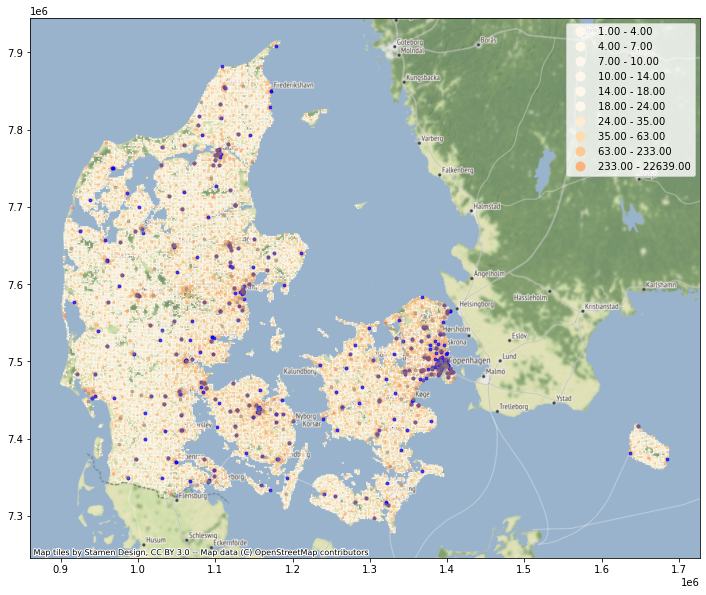

In [37]:
#import contextily as ctx  # Husk at køre denne linje første gang for background map 
new_df = new_df.to_crs(epsg =  3857)
gdf = gdf.to_crs(epsg =3857)
f, ax = plt.subplots(1, figsize=(12, 20))
ax = new_df.plot(column='TOT_P',ax=ax, legend=True, cmap='OrRd',norm=mpl.colors.Normalize(vmin=5, vmax=15), scheme='quantiles', k=10)
ctx.add_basemap(ax)
gdf_Type6['geometry'].plot(ax=ax , markersize=8 , color='blue' ,  alpha=0.7)
gdf_Type7['geometry'].plot(ax=ax , markersize=8 , color='grey', alpha=0.4)
gdf_Type8['geometry'].plot(ax=ax , markersize=8 , color='red', alpha=0.1)
plt.show()

<AxesSubplot:>

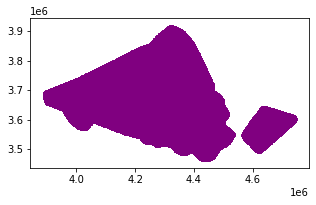

In [34]:
DK_shape.plot(figsize=(5,5), edgecolor="purple", facecolor="None")


In [12]:
import contextily as ctx

ImportError: DLL load failed while importing _base: Den angivne procedure blev ikke fundet.